In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
from astropy.timeseries import LombScargle
import george
from george import kernels
from scipy.interpolate import interp1d
import time
from scipy import stats
from functions import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
info = pd.read_csv('lc_example/OGLE_Roman_field_variables.CSV')

In [21]:
i = info.index[info.ID == 'OGLE-BLG-RRLYR-03350']
ID = info.ID[i].values[0]
period = info.P_1[i].values[0]
df = read_OGLE_lc(ID, period)

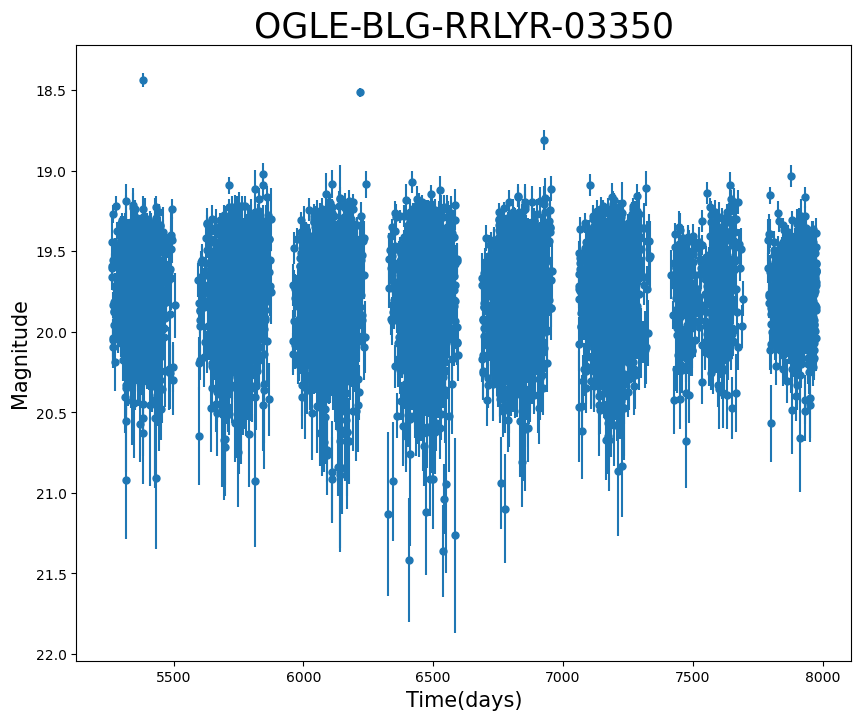

In [22]:
plt.figure(figsize=(10,8))


plt.errorbar(df.t, df.m,yerr=df.e, fmt = '.', ms=10)
plt.xlabel('Time(days)', size=15)
plt.ylabel('Magnitude', size=15)
plt.title(ID, size=25)
plt.gca().invert_yaxis()


# plt.savefig('OGLE_lc_gapped_full.png',facecolor='white', edgecolor='none')

In [23]:
df_gapped, df, p = gap_remover(ID, period)

/Users/somayeh/Library/Mobile Documents/com~apple~CloudDocs/Research/Roman_lc_gen/functions.py:131: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_temp)


In [42]:
t_new = np.linspace(0,3,100)

In [53]:
# Set up the Gaussian process.
kernel =  kernels.CosineKernel(np.log(3)) #+ kernels.Matern32Kernel(150)

In [54]:
gp = george.GP(kernel, solver= george.HODLRSolver)
print ("hyper parameters: ",gp.kernel)

hyper parameters:  CosineKernel(log_period=1.0986122886681098, ndim=1, axes=array([0]))


In [ ]:
x = pd.concat([df_gapped.sort_values(by=['phase']).phase, 
               df_gapped.sort_values(by=['phase']).phase+1,
              df_gapped.sort_values(by=['phase']).phase+2])
y = pd.concat([df_gapped.sort_values(by=['phase']).m, 
               df_gapped.sort_values(by=['phase']).m,
              df_gapped.sort_values(by=['phase']).m])
e = pd.concat([df_gapped.sort_values(by=['phase']).e, 
               df_gapped.sort_values(by=['phase']).e,
              df_gapped.sort_values(by=['phase']).e])
X = t_new

start = time.process_time()

# Pre-compute the factorization of the matrix.
gp.compute(x, e)


mu, cov = gp.predict(y, X)
std = np.sqrt(np.diag(cov))

print('The time it took to run this cell is:',round(time.process_time() - start, 3), 'seconds')

In [ ]:
bin_means, bin_edges, binnumber = stats.binned_statistic(x, y,\
                                                         statistic='mean', bins=30)

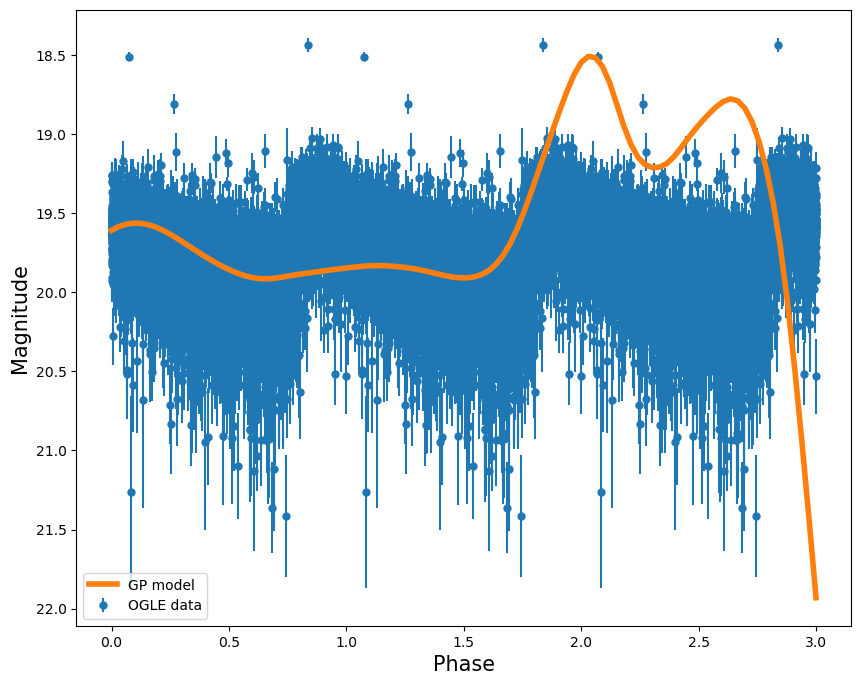

In [52]:
plt.figure(figsize=(10,8))


plt.errorbar(x, y,yerr=e, fmt = '.', ms = 10, label = 'OGLE data')

plt.savefig('OGLE_lc_gapped_phased_plus_GP.png')
# plt.plot(bin_edges[:-1], bin_means)
plt.plot(X,mu, linewidth = 4, label='GP model', zorder=11)
plt.xlabel('Phase', size=15)
plt.ylabel('Magnitude', size=15)
plt.legend()
plt.gca().invert_yaxis()


# plt.savefig('OGLE_lc_gapped_phased_plus_GP.png',facecolor='white', edgecolor='none')

In [12]:
def gap_filler(X,mu, t_i, t_f, p):
    
    X_new =[]
    mu_new = []
    
    model = interp1d(X,mu)
    
    ph_i = (t_i/p) - np.fix(t_i/p)
    ph_f = (t_f/p) - np.fix(t_f/p)
    
    for i in range((ph_f-ph_i)+1):
        X_new.append(X+i)
        mu.append


# model(1.2)

In [13]:
df_gap = df_gapped[df_gapped.t.diff()>50]

t_gap = []
mu_gap = []

for ind in df_gap.index:
    ph_i = int(np.fix(df_gapped.t[ind-1]/p))
    ph_f = int(np.fix(df_gapped.t[ind]/p))
    c = ph_f-ph_i

    t_gap = np.concatenate([t_gap,np.concatenate([(p*(X[:-1]+ph_i+i)) for i in range(c+1)])])
    mu_gap = np.concatenate([mu_gap, np.concatenate([((mu[:-1])) for i in range(c+1)])])
    
model = interp1d(t_gap, mu_gap)

In [14]:
Z = [x for _,x in sorted(zip(np.concatenate([df_gapped.t.values,t_gap]),
                             np.concatenate([df_gapped.m.values, mu_gap])))]



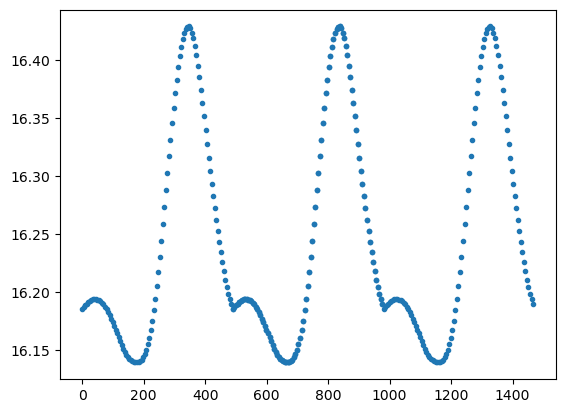

In [15]:
plt.plot(t_gap, mu_gap, '.')

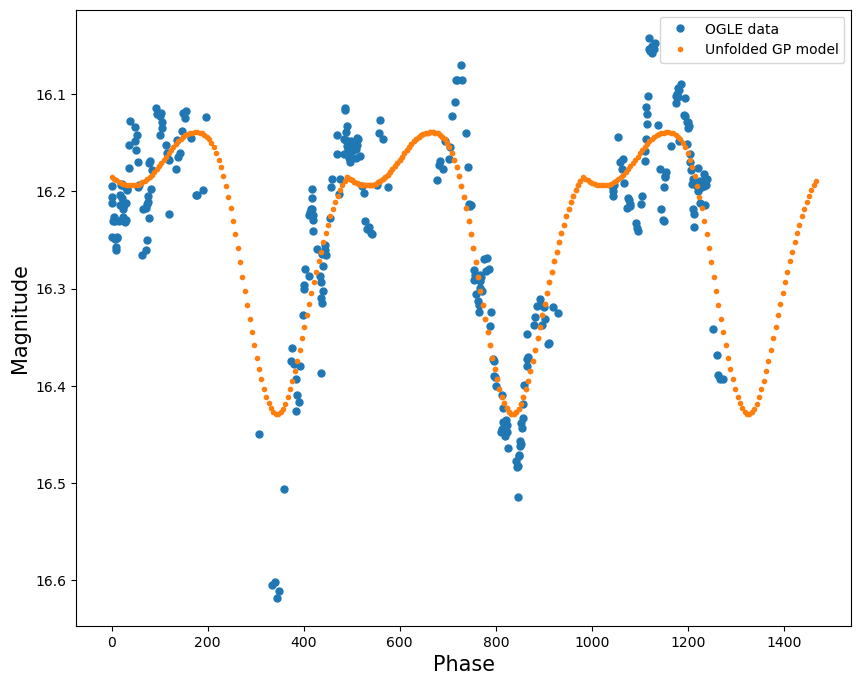

In [16]:
plt.figure(figsize=(10,8))


plt.plot(df_gapped.t, df_gapped.m, '.', ms = 10, label='OGLE data')
plt.plot(t_gap, mu_gap, '.',label = 'Unfolded GP model')
# plt.axvline(df_gapped.t[247])
plt.xlabel('Phase', size=15)
plt.ylabel('Magnitude', size=15)
plt.legend()
plt.gca().invert_yaxis()


# plt.savefig('OGLE_lc_gapped_full_plus_unfolded_gp_model.png',facecolor='white', edgecolor='none')

In [17]:
t_new = np.loadtxt('lc_example/ulwdc1_208_W149.txt', usecols=0)
t_new = t_new - min(t_new)

t_roman = np.linspace(0, max(t_new),1000)

df_gapped, df, p = gap_remover(ID, period)
    
df_roman = fix_sampling(df, t_roman, period)

/Users/somayeh/Library/Mobile Documents/com~apple~CloudDocs/Research/Roman_lc_gen/functions.py:131: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_temp)


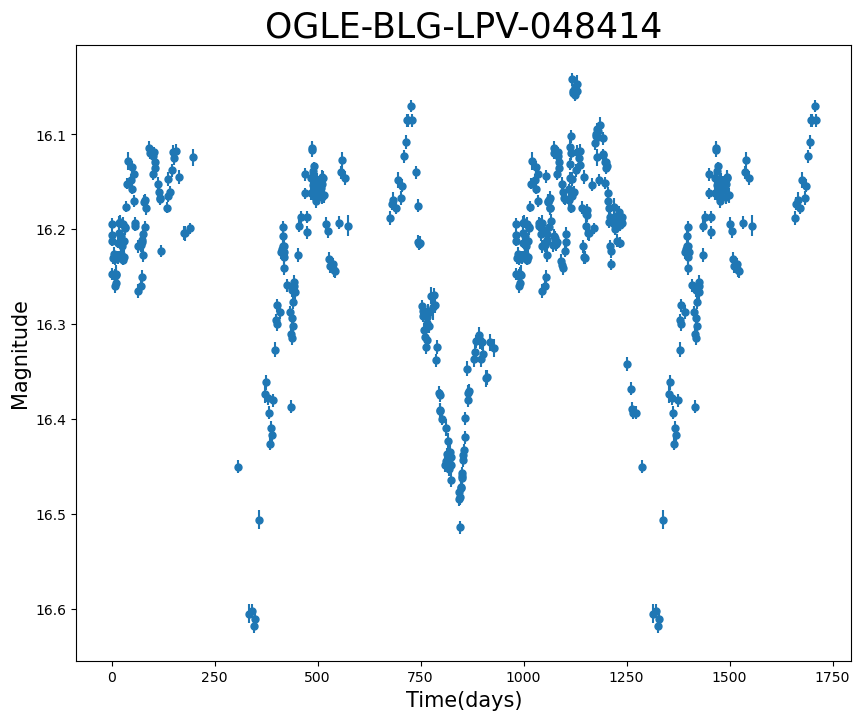

In [20]:
plt.figure(figsize=(10,8))


plt.errorbar(df.t, df.m,yerr=df.e, fmt = '.', ms=10)
plt.xlabel('Time(days)', size=15)
plt.ylabel('Magnitude', size=15)
plt.title(ID, size=25)
plt.gca().invert_yaxis()


# plt.savefig('OGLE_lc_no_gap_full.png',facecolor='white', edgecolor='none')